# Tweet Sentiment Extraction 😇 😑 😣

## Section 1:

### Project Definition
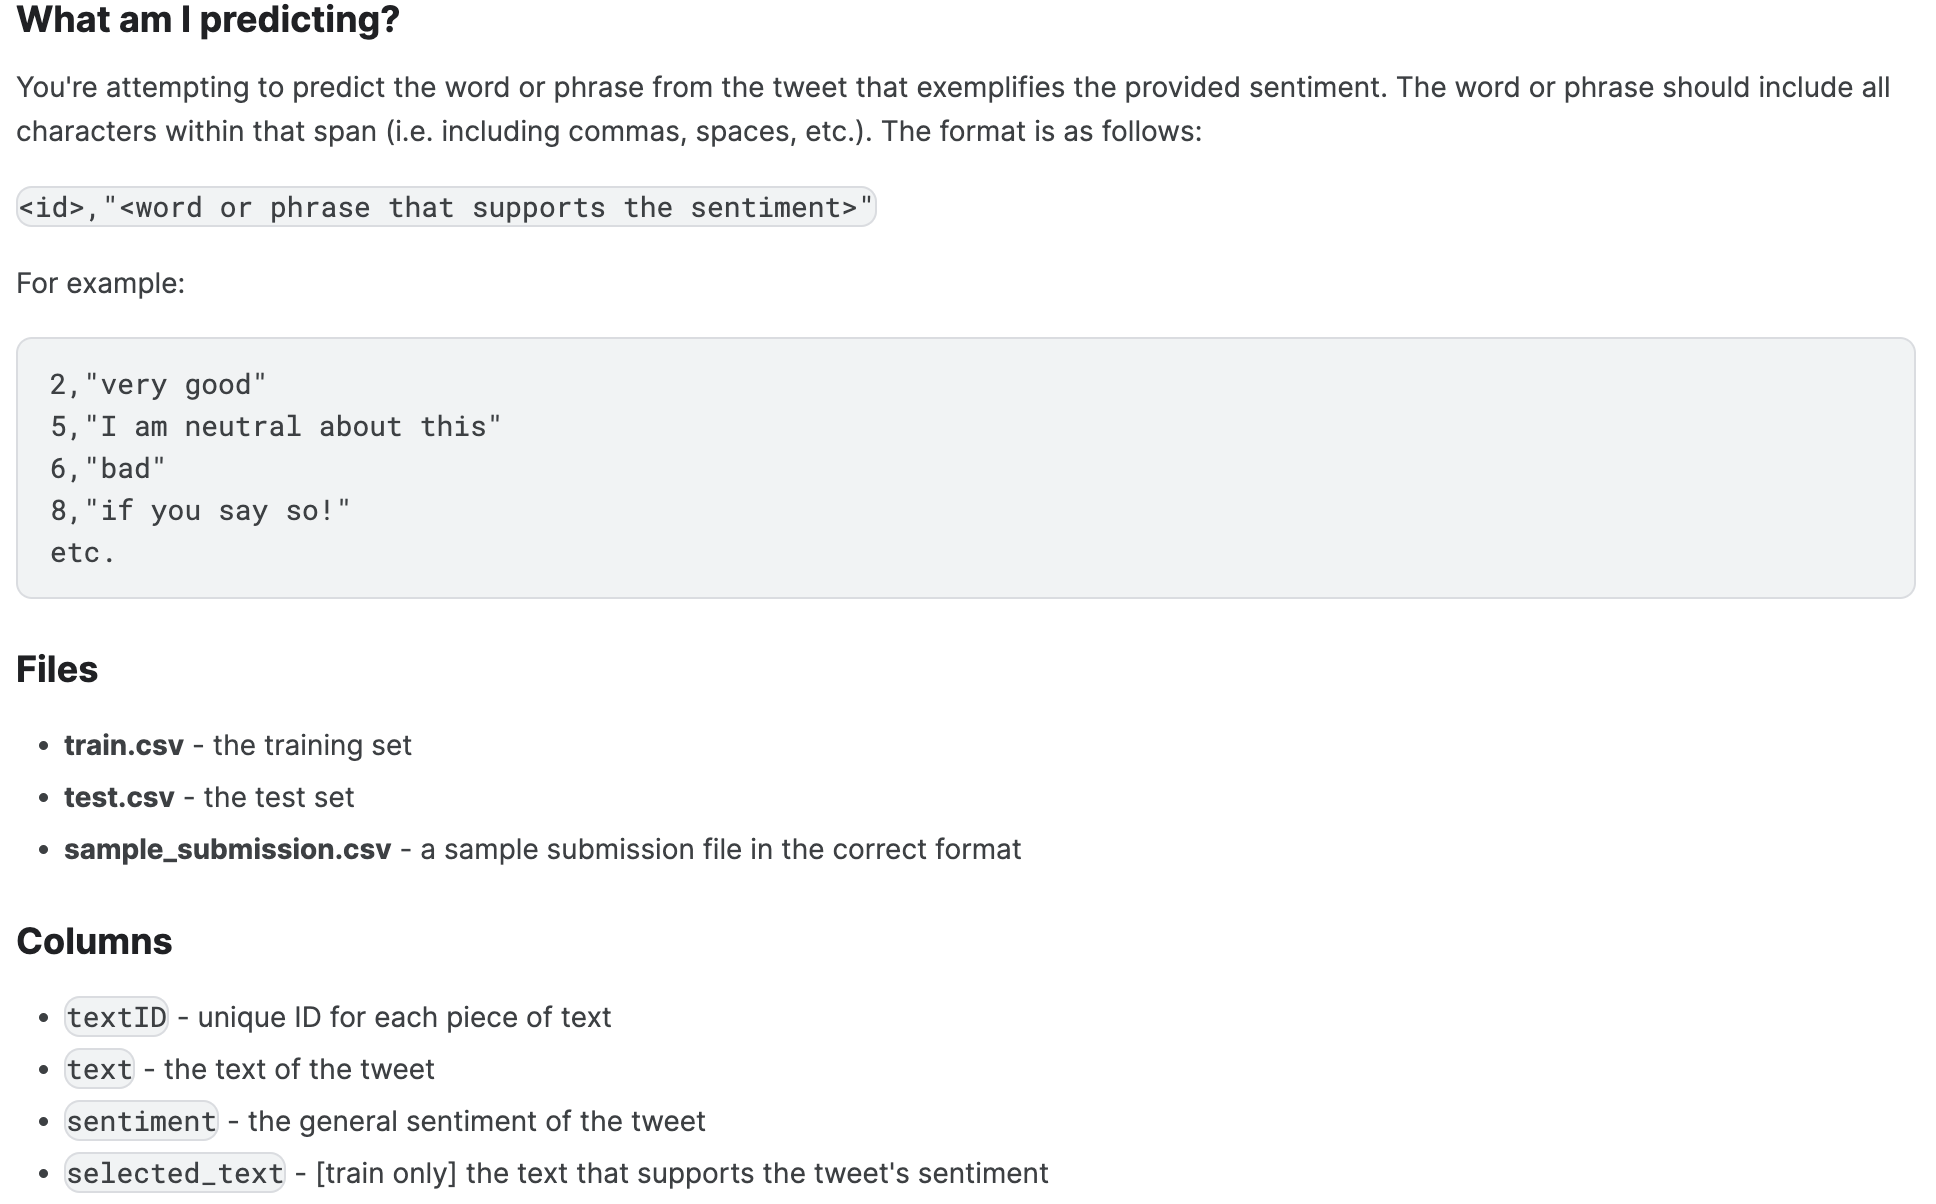

### Problem Statement:
To identify the potential parts of `sentence` that essentially play the role in Sentiment Classification decision.

### Approach:

1. Process the Text data  
2. Model a `sentiment sentence` model  
3. Predict the `selected_text` influencing the sentiment

Explained below:
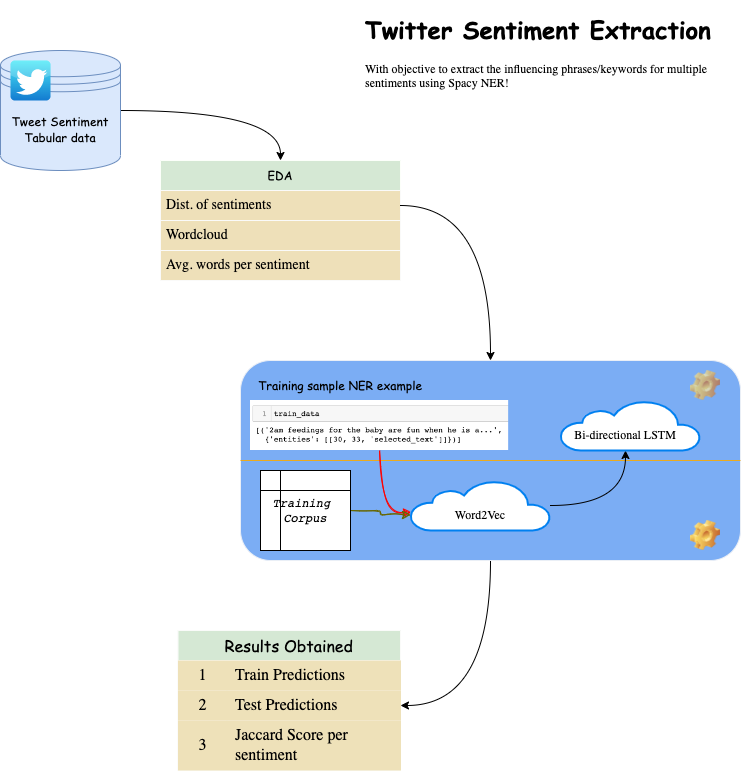
### Metrics:

We intend to use `Spacy NER (Named Entity Recognition)` model to extract the `entities` per sentiment. Hence we use **`Jaccard score`** method to find the common words in 2 sets. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
from tqdm import tqdm
from spacy.training import Example
import os
from spacy import displacy
from pathlib import Path
from nltk.corpus import stopwords
import string

import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid", palette="pastel")
sns.set(font_scale = 2)

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
sample_submission_data = pd.read_csv('../data/sample_submission.csv')

In [3]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [5]:
sample_submission_data.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


#### Quick Checks:

1. train_data has 4 columns:  
    i. `testID`  
    ii. `text`  
    iii. `select_text`  
    iv. `sentiment`  
    
2. test_data has 3 columns:  
    i. `testID`  
    ii. `text`  
    iii. `sentiment`  
    
3. sample_submission_data has 2 columns:  
    i. `testID`  
    ii. `select_text`  

## Section 2: 

### Quick EDA:

1. Exploring couple of basic `inferential` and `statistical` graphs to identify the pattern/behaviour among sentiments.  
    i. Distribution of sample for `sentiment` column.  
    ii. Quick `wordcloud` to look for `frequency of words` for column `selected_text` .  
    iii. We will also try to plot `text` column based on our pre-processing pipeline.  
    
2. I would also like to just take a precautionary measure to find if any duplicate `textID` isn't present in test_data.  

3. 

#### Let's start some Digging! 🐿️

Total number of records: 27481
Sentiment Neutral has 11118 records
Sentiment Positive has 8582 records
Sentiment Negative has 7781 records


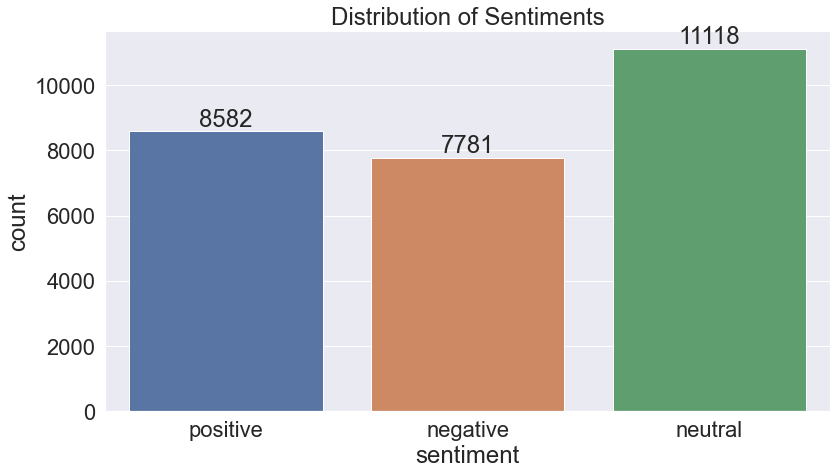

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None

Missing data 'textID': ['fdb77c3752']

DType for 'textID' is object
DType for 'text' is object
DType for 'selected_text' is object
DType for 'sentiment' is object

Duplicates if any? 0


In [6]:
def check_sentiment_dist(sentiment_column):
    
    # printing number of sentiments vs total records
    print(f'Total number of records: {len(sentiment_column)}')
    for sentiment,count in (sentiment_column.value_counts().to_dict()).items():
        print(f'Sentiment {sentiment.capitalize()} has {count} records')
        
    classes = ['positive','negative','neutral']
    
    # plotting the Samples
    title= 'Distribution of Sentiments'
    plt.figure(figsize=(13,7))
    p = sns.countplot(x=sentiment_column, order = classes)
    for i, bar in enumerate(p.patches):
        count = list(sentiment_column.values).count(classes[i])
        plt.text(i, bar.get_height(), count, ha='center', va='bottom')
        plt.title(title)

    # we will open the below line to save the plot and run notebook from scratch
#     plt.savefig(f'../visualizations/{title}.png');

    plt.show();
    return 

check_sentiment_dist(sentiment_column = train_data['sentiment'])

def check_statisticals(sentiment_dataframe):
    
    # Don't forget to check for Null
    print(sentiment_dataframe.info())

    # Quickly pull in the missing data
    missing_data = sentiment_dataframe[sentiment_dataframe.isna().any(axis=1)]
    print(f"\nMissing data 'textID': {missing_data['textID'].values}\n")
    
    # Checking the dtypes for the columns
    for col in sentiment_dataframe.columns:
        print(f"DType for '{col}' is {(sentiment_dataframe[col]).dtype}")
        
    # Checking if any duplicates in textID as it should be unique
    duplicates = sentiment_dataframe[sentiment_dataframe.duplicated()]
    print(f'\nDuplicates if any? {duplicates.shape[0]}')
    
check_statisticals(train_data)

- Could there be any bias in data towards having more `neutral feedbacks or words` ?          
- Very slight bias between `+ve and -ve` samples.  
- No `duplicates`, that is a good sign, and approximate 1 misleading entry for `null value` detection. So that is also a good sign!  
- Our `'dtypes`' are also spot on and hence we are good to create our required **`wordclouds`** and move ahead.


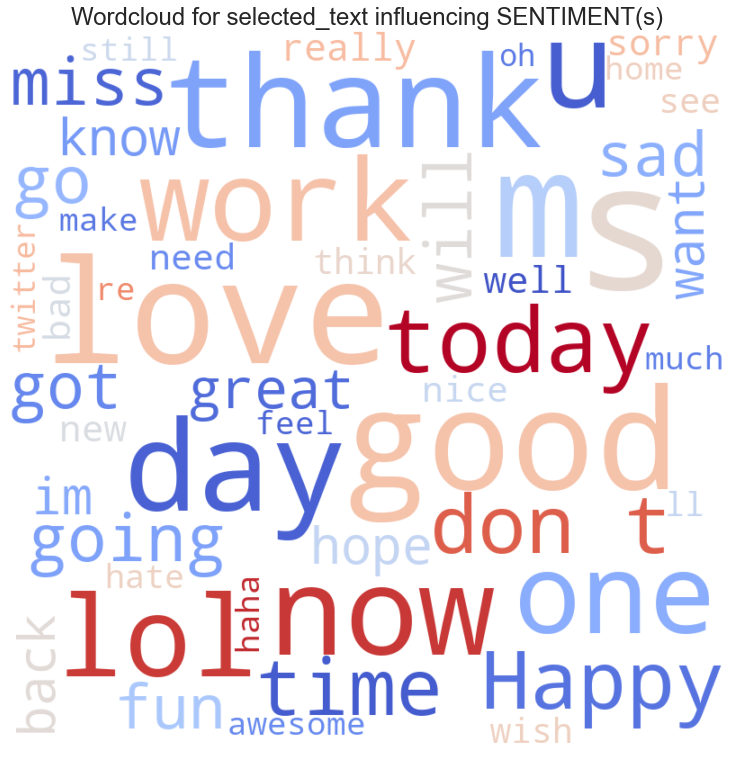

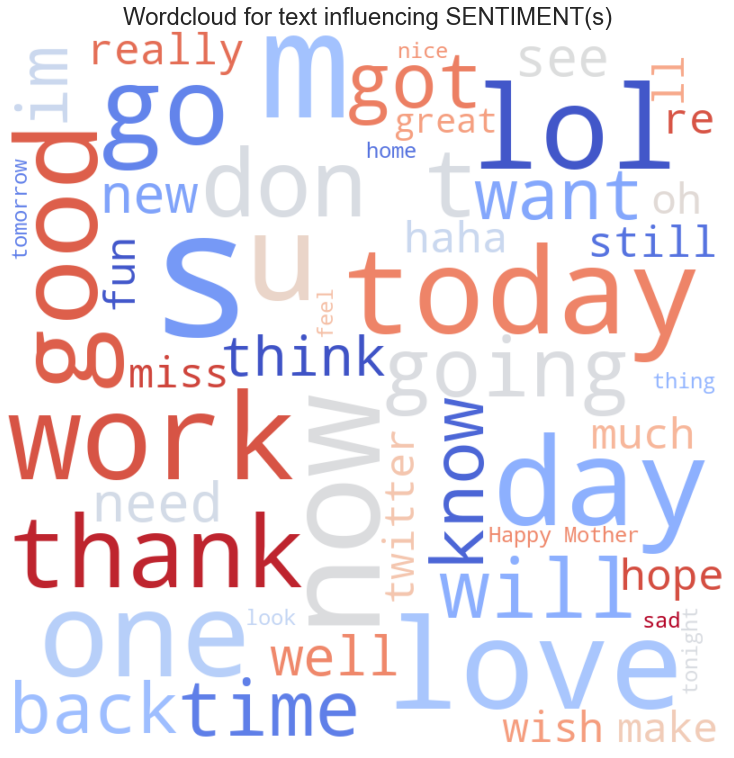

In [7]:
def create_wordcloud(series_to_plot):
    
    # we join all the word in that column
    text = " ".join(str(x) for x in series_to_plot)

    title = f'Wordcloud for {series_to_plot.name} influencing SENTIMENT(s)'
    # Generate a wordcloud
    wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='coolwarm', max_words=50, max_font_size=200, relative_scaling=0.5).generate(text)


    # Set size and plot the wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title)
    
        # we will open the below line to save the plot and run notebook from scratch
#     plt.savefig(f'../visualizations/{title}.png');
    plt.show()
    
    return 

create_wordcloud(train_data['selected_text'])
create_wordcloud(train_data['text'])

# Let's quickly drop the null valued row
train_data = train_data.dropna()

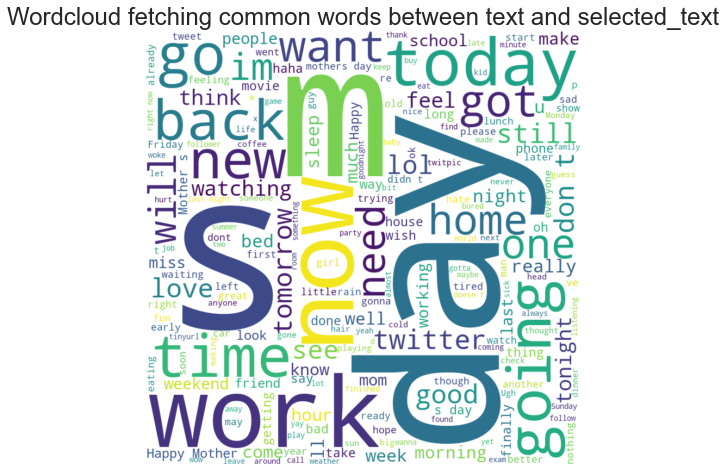

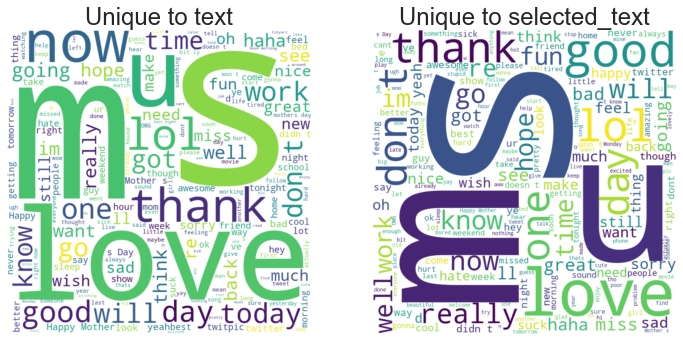

In [8]:
# Why don't we build a wordcloud for the common and un-common words between selected_text and text columns

def wordcloud_between_columns(df,column1,column2,intersection):
    df[column1] = df[column1].apply(lambda x: str(x) if isinstance(x, float) else x)
    df[column2] = df[column2].apply(lambda x: str(x) if isinstance(x, float) else x)
    
    if intersection == True:
        title = f'Wordcloud fetching common words between {column1} and {column2}'
        # create common words
        common_words = " ".join(set(df[column1]).intersection(set(df[column2])))
        
        # Generate a wordcloud
        wordcloud = WordCloud(width=800, height=800, background_color='white').generate(common_words)
        
        # Plot the wordcloud
        plt.figure(figsize=(8,8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
    
        # we will open the below line to save the plot and run notebook from scratch
#         plt.savefig(f'../visualizations/{title}.png');
        plt.show()
        
    else:
        title = f'Wordcloud fetching specific words to {column1} and to {column2}'
        # Find the set of words that are unique to each column
        unique_to_column1 = " ".join(set(df[column1]).difference(set(df[column2])))
        unique_to_column2 = " ".join(set(df[column2]).difference(set(df[column1])))

        # Generate wordclouds for each set of unique words
        wordcloud1 = WordCloud(width=800, height=800, background_color='white').generate(unique_to_column1)
        wordcloud2 = WordCloud(width=800, height=800, background_color='white').generate(unique_to_column2)

        # Plot the wordclouds side by side
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(wordcloud1, interpolation='bilinear')
        axs[0].axis('off')
        axs[0].set_title(f'Unique to {column1}')
        axs[1].imshow(wordcloud2, interpolation='bilinear')
        axs[1].axis('off')
        axs[1].set_title(f'Unique to {column2}')
        
        # we will open the below line to save the plot and run notebook from scratch
#         plt.savefig(f'../visualizations/{title}.png');
        plt.show()
        
    return
        

wordcloud_between_columns(df = train_data,
                         column1='text',
                         column2='selected_text',
                         intersection=True)


wordcloud_between_columns(df = train_data,
                         column1='text',
                         column2='selected_text',
                         intersection=False)

In [9]:
# Something popped in my head!
# Let's find out the average number of words mentioned per Sentiment

def words_per_sentiment(sentiment_data):
    classes = ['positive','negative','neutral']
    for sentiment in classes:
        subset = sentiment_data[sentiment_data.sentiment == sentiment]
        average_words = round(np.mean(subset['selected_text'].str.split().str.len()),2)
        print(f'{sentiment.capitalize()} words have - {average_words} words on average!')

words_per_sentiment(train_data)

Positive words have - 3.52 words on average!
Negative words have - 3.96 words on average!
Neutral words have - 12.07 words on average!


WOW !.  
This is something interesting. My best explanation:  
<u>`If user marks a sentiment NEUTRAL, they feel obligated towards explaining their selection! Just look at India's stand in RUSSIA vs UKRAINE war and USA's stand between Inda and Pakistan`</u> .    
Though people **liking-disliking** review are spot on and move on! 
🆕

## Section 3:

### Data Preprocessing:

We need a specific dataframe structure for `NER` extraction.  
Columns should be in dataframe:  
1. `text`  
2. dictionary in format: **`{'entities': [[start_index,end_index,'column_from_which_entity_is_mapped']]}`**  
    - For each row, we extract `text` and `selected_text` and look for the substring `selected_text` in `text`.  
    - We add the index value to the lenght of `selected_text` making an assumption that it is continuous.

In [10]:
def get_training_data(sentiment,sentiment_df):
    train_data = []
    
    # loop in each row to fetch 'text' and 'sentiment'
    for index, row in sentiment_df.iterrows():
        if row.sentiment == sentiment:
            # fetch the 'selected_text' for current sentiment
            selected_text = row.selected_text
            text = row.text
            # fetch the starting index of 'selected_text' in 'text'
            start = text.find(selected_text)
            # assuming that the sentence is of continous words/length
            end = start + len(selected_text)
            # we return the entities created.
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

# Running for 'Positive' sentiment
sentiment = 'positive'
pos_train_data = get_training_data(sentiment,train_data)
pos_df = pd.DataFrame(pos_train_data,columns = ['text','entities'])

# Running for 'Negative' sentiment
sentiment = 'negative'
neg_train_data = get_training_data(sentiment,train_data)
neg_df = pd.DataFrame(neg_train_data,columns = ['text','entities'])

# Running for 'Neutral' sentiment
sentiment = 'neutral'
neu_train_data = get_training_data(sentiment,train_data)
neu_df = pd.DataFrame(neu_train_data,columns = ['text','entities'])

In [11]:
# Making sure, we have a master dataframe
mster_df = pd.concat([pos_df,neg_df,neu_df]).reset_index(drop=True)

def fetch_extracted_entites(master_df):
    
    # Just find back the 'selected_text'
    positional_info = master_df['entities'].apply(lambda x: x['entities'][0][:2]).values.tolist()
    my_entites = []
    for p in range(len(positional_info)):
        my_entites.append(master_df.iloc[p,0][positional_info[p][0]:positional_info[p][-1]])
    
    master_df['selected_text_entities'] = my_entites
    return master_df

master_df = fetch_extracted_entites(mster_df)
master_df.to_csv('../data/training_data_with_entities.csv')

In [12]:
master_df.head(7)

,text,entities,selected_text_entities
0,2am feedings for the baby are fun when he is a...,"{'entities': [[30, 33, 'selected_text']]}",fun
1,Journey!? Wow... u just became cooler. hehe....,"{'entities': [[11, 39, 'selected_text']]}",Wow... u just became cooler.
2,I really really like the song Love Story by Ta...,"{'entities': [[16, 20, 'selected_text']]}",like
3,Playing Ghost Online is really interesting. Th...,"{'entities': [[31, 43, 'selected_text']]}",interesting.
4,"the free fillin` app on my ipod is fun, im add...","{'entities': [[0, 51, 'selected_text']]}","the free fillin` app on my ipod is fun, im add..."
5,juss came backk from Berkeleyy ; omg its madd ...,"{'entities': [[46, 49, 'selected_text']]}",fun
6,I`m going home now. Have you seen my new twitt...,"{'entities': [[57, 74, 'selected_text']]}",Quite....heavenly


### Implementation Steps

1. Explore **`Spacy`** library and show the following results:    
 a. Word Embeddings result/vizualization  
 b. Train on one **single training-text** our **Word2Vec model** with spacy **Bi-directional** LSTM model  
 c. Predict and score the same.  
2. Create a blank `spacy` model.  
3. Fetch for `ner` pipeline.  
4. Tag `entities` using `annotations.get('entities')` .  
5. Start training in `Minibatch` fashion to make sure most of the pattern is captured.  
6. Print `loss` at each step


#### Let's quickly understand the Word-Embedding working and difference between 2 spcay embeddings provided.

Word Embeddings are high dimensional data represented using trained word-vector packages.
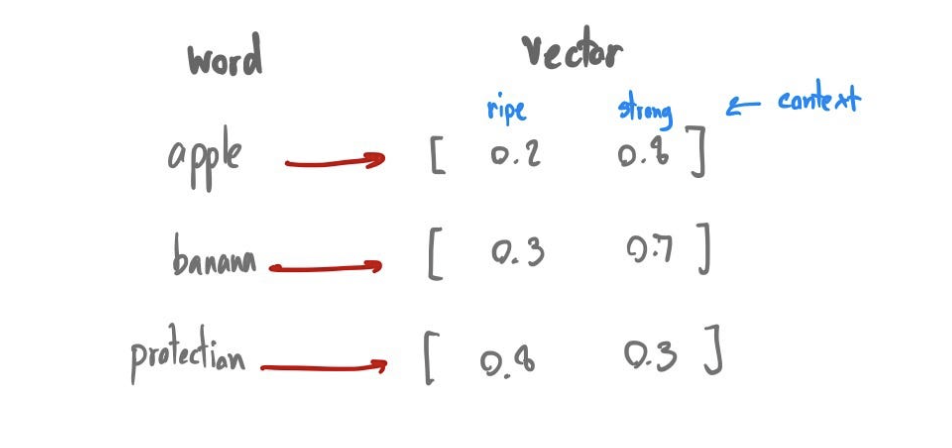

Here the intuition is to weigh out each word using context relationship. Example, here `Apple` is weighted against `rip & strong`, we can even add properties like `freshness, color, texture` to extract more information.  
This is where **Spacy's Word2Vec** model comes into picture and helps us create these contextual features agains our labelled entities.

##### `en_core_web_md` vs `en_core_web_sm`

**`en_core_web_md`**:  
    - `en_core_web_md` is a ***larger model, with more features and higher accuracy, but it requires more memory to run.*** It includes a larger vocabulary and can recognize more named entities, like people, organizations, and locations. It also has more accurate syntactic parsing, which means it can better understand the grammatical structure of a sentence.
    
**`en_core_web_sm`**:  
    - `en_core_web_sm`, on the other hand, is a ***smaller and simpler model, which is faster to run and requires less memory. It has a smaller vocabulary and can recognize fewer named entities,*** but it can still perform basic syntactic parsing and other NLP tasks.

In [13]:
# Training the Spacy 'NER' for one single Training example
from spacy import displacy
# Define the training data
train_data_sample = [("2am feedings for the baby are fun when he is silent", {"entities": [[30, 33, "selected_text"]]}),
             ('Journey!? Wow... u just became cooler.  hehe... (is that possible!?)',{'entities': [[11, 39, 'selected_text']]}),
             ('Missing my morning work out cause my bench press is back in Jakarta  goodluck diga! Test will be easy peasy! Hehehe',{'entities': [[69, 77, 'selected_text']]})]

# Convert the training data to a pandas DataFrame
df = pd.DataFrame(train_data_sample, columns=["text", "entities"])

# Load the Word2Vec model
# word2vec_model_path = "/path/to/word2vec/model"
nlp = spacy.load('en_core_web_md')

# Add the NER component to the pipeline
ner = nlp.create_pipe("ner")
#nlp.add_pipe("ner")

# Add the labels to the NER component
for _, annotations in df.iterrows():
    for ent in annotations["entities"]:
        ner.add_label(ent[2])

# Train the NER model
optimizer = nlp.begin_training()
for i in range(50):
    losses = {}
    batches = minibatch(train_data_sample, size=compounding(4.0, 500.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        examples = []
        for i in range(len(texts)):
            doc = nlp.make_doc(texts[i])
            examples.append(Example.from_dict(doc, annotations[i]))

        nlp.update(examples, drop=0.2, losses=losses,sgd=optimizer)
print("Losses", losses)
    
# Test the NER model
doc1 = nlp("2am feedings for the baby are fun when he is silent")
print([(ent.text, ent.label_) for ent in doc1.ents])
displacy.render(doc1, style = 'ent', jupyter= True, options= {'distance': 140})

doc2 = nlp('Journey!? Wow... u just became cooler.  hehe... (is that possible!?)')
print([(ent.text, ent.label_) for ent in doc2.ents])
displacy.render(doc2, style = 'ent', jupyter= True, options= {'distance': 140})

doc3 = nlp('Missing my morning work out cause my bench press is back in Jakarta  goodluck diga! Test will be easy peasy! Hehehe')
print([(ent.text, ent.label_) for ent in doc3.ents])
displacy.render(doc3, style = 'ent', jupyter= True, options= {'distance': 140})

Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 5.1651813368989285e-08}
[('fun', 'selected_text')]


[]


[('goodluck', 'selected_text')]


In [14]:
# This part if quite interesting

nlp = spacy.load("en_core_web_sm")
sentences = [train_data_sample[0][0], train_data_sample[1][0]]
for sent in sentences:
    doc = nlp(sent)
    svg = displacy.render(doc, style="dep", jupyter=False)
    file_name = '-'.join([w.text for w in doc if not w.is_punct]) + ".svg"
    output_path = Path("../visualizations/" + file_name)
    output_path.open("w", encoding="utf-8").write(svg)

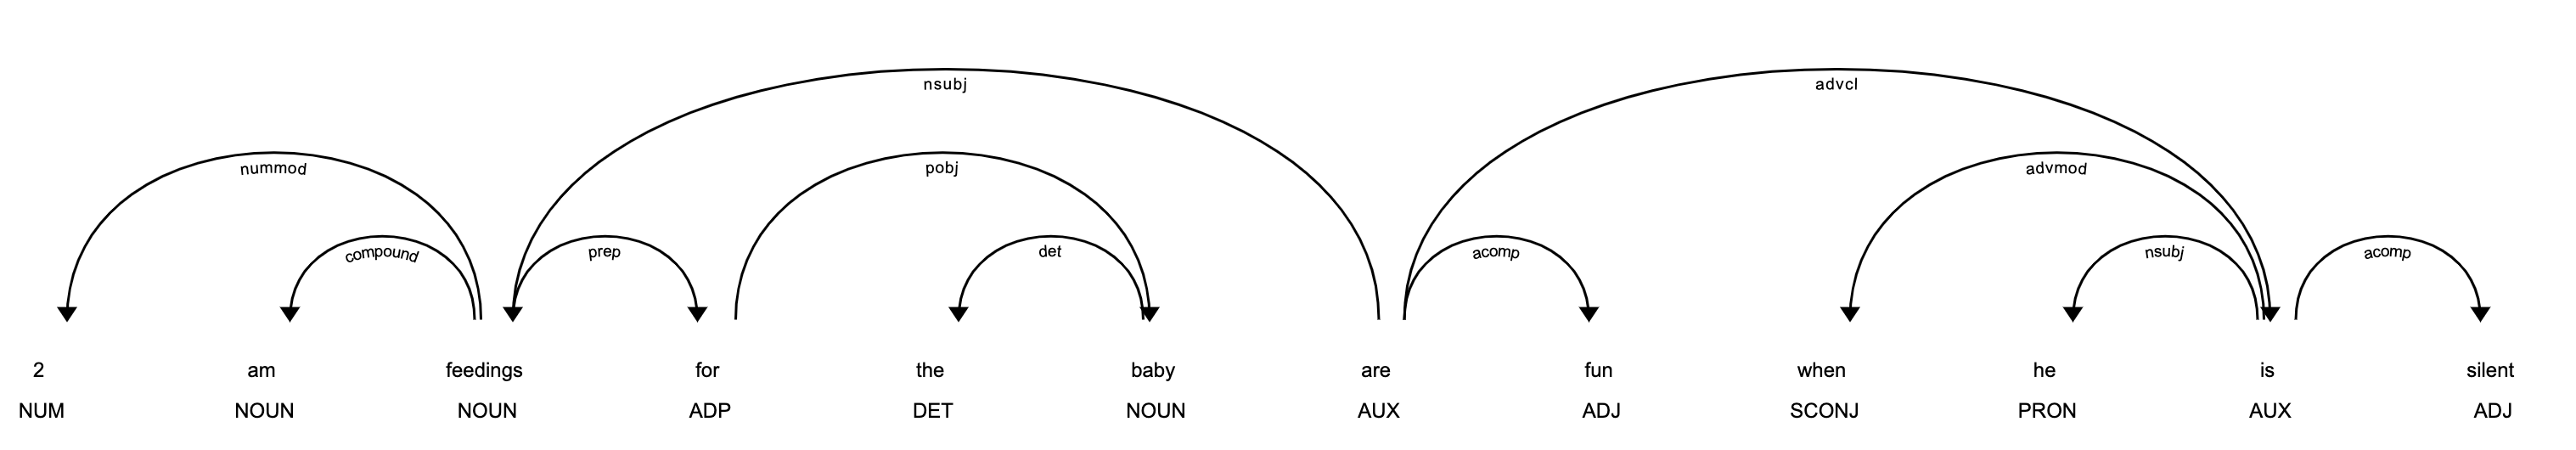

and 

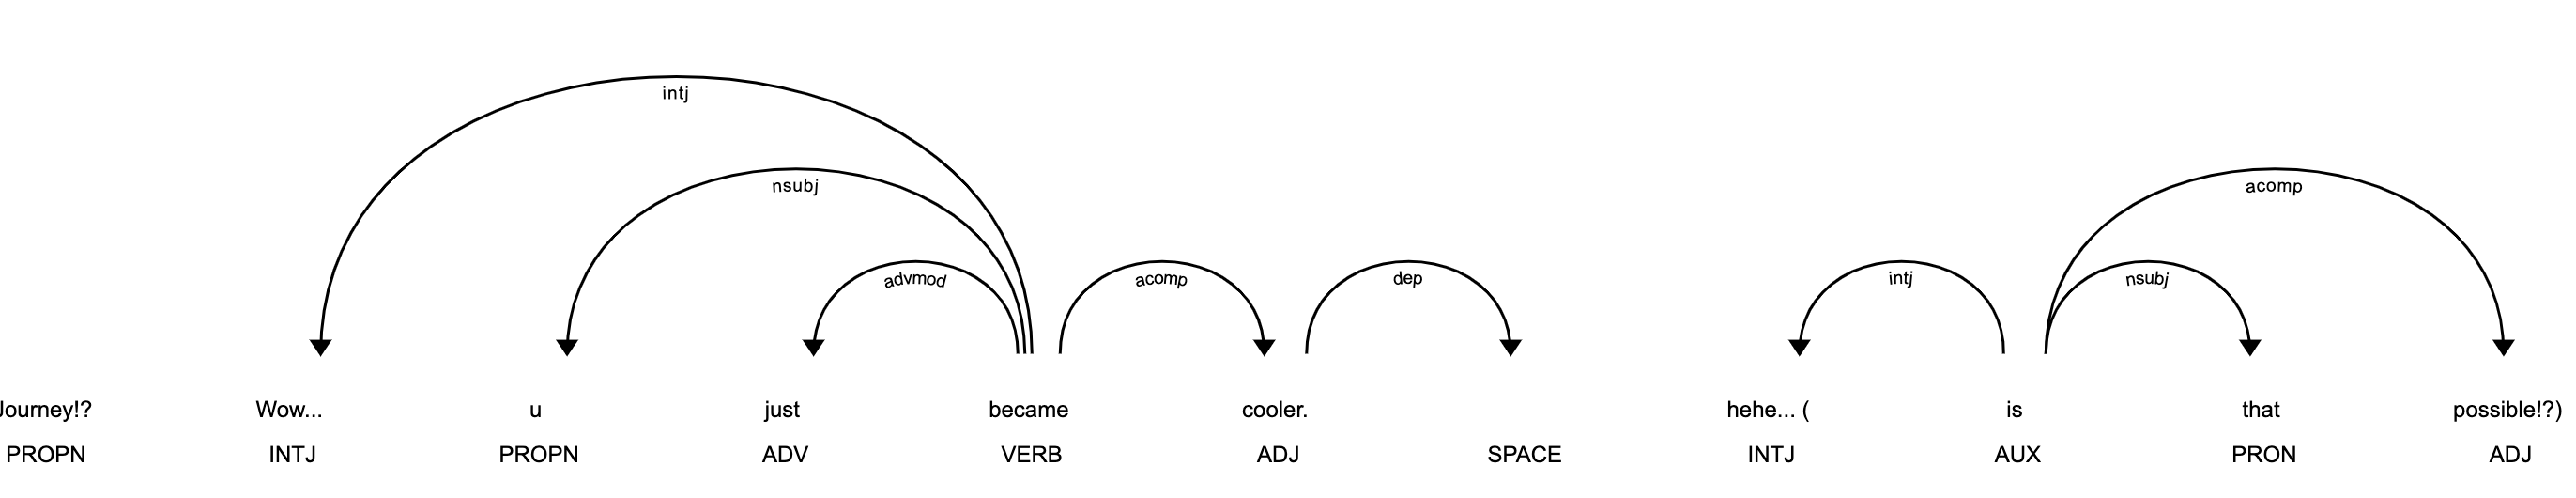

In [15]:
# We need to save our Models finally
def save_model(output_dir, nlp, new_model_name):
    output_dir = f'../models/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir) 
   
# fetch model paths quickly
def get_model_out_path(sentiment):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '../models/model_pos'
    elif sentiment == 'negative':
        model_out_path = '../models/model_neg'
    else:
        model_out_path = '../models/model_neu'
    return model_out_path

In [16]:
# Now based upon the experiment we did above using Word2Vec + Spacy NER
# We would like to train the model on Sentiments, individually.
def train_bilstm_ner(train_data, output_dir,n_iter=20, size = 4.0, max_batch_size = 500.0, factor = 1.001,fine_tuned = False):

    nlp = spacy.load("en_core_web_md")  # Load word2vec model
    print("Created blank 'en' model")

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe('ner', last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        
        # batch up the examples using spaCy's minibatch
        nlp.begin_training()
        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(size, max_batch_size, factor))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)

                examples = []
                for i in range(len(texts)):
                    doc = nlp.make_doc(texts[i])
                    examples.append(Example.from_dict(doc, annotations[i]))

                nlp.update(examples, drop=0.3, losses=losses)

            print("Losses", losses)
            
    if fine_tuned == False:
        save_model(output_dir, nlp, 'st_ner')
    else:
        save_model(output_dir + '_refined', nlp, 'st_ner')
        

In [17]:
model_path = get_model_out_path('positive')
model_pos = train_bilstm_ner(pos_train_data,model_path,n_iter=40,size = 60,max_batch_size = 300.0 ,factor = 1.05,fine_tuned = False)
model_path = get_model_out_path('negative')
model_neg = train_bilstm_ner(neg_train_data,model_path,n_iter=40,size = 60,max_batch_size = 300.0 ,factor = 1.05,fine_tuned = False)
model_path = get_model_out_path('neutral')
model_neu = train_bilstm_ner(neu_train_data,model_path,n_iter=40,size = 60,max_batch_size = 300.0 ,factor = 1.05,fine_tuned = False)

Created blank 'en' model


  2%|██▊                                                                                                              | 1/40 [00:14<09:22, 14.42s/it]

Losses {'ner': 23140.497065531657}


  5%|█████▋                                                                                                           | 2/40 [00:29<09:17, 14.66s/it]

Losses {'ner': 12327.430609735085}


  8%|████████▍                                                                                                        | 3/40 [00:43<08:51, 14.35s/it]

Losses {'ner': 11893.127916151238}


 10%|███████████▎                                                                                                     | 4/40 [00:57<08:32, 14.23s/it]

Losses {'ner': 11564.758080435862}


 12%|██████████████▏                                                                                                  | 5/40 [01:11<08:18, 14.23s/it]

Losses {'ner': 11402.183727553023}


 15%|████████████████▉                                                                                                | 6/40 [01:26<08:07, 14.33s/it]

Losses {'ner': 11072.922115005194}


 18%|███████████████████▊                                                                                             | 7/40 [01:40<07:48, 14.21s/it]

Losses {'ner': 10799.801443346247}


 20%|██████████████████████▌                                                                                          | 8/40 [01:54<07:33, 14.17s/it]

Losses {'ner': 10657.245168385754}


 22%|█████████████████████████▍                                                                                       | 9/40 [02:08<07:20, 14.20s/it]

Losses {'ner': 10545.330782935835}


 25%|████████████████████████████                                                                                    | 10/40 [02:22<07:05, 14.19s/it]

Losses {'ner': 10411.790610951897}


 28%|██████████████████████████████▊                                                                                 | 11/40 [02:36<06:51, 14.19s/it]

Losses {'ner': 10341.868614501573}


 30%|█████████████████████████████████▌                                                                              | 12/40 [02:50<06:36, 14.17s/it]

Losses {'ner': 10275.368904160858}


 32%|████████████████████████████████████▍                                                                           | 13/40 [03:05<06:24, 14.24s/it]

Losses {'ner': 10122.253138593143}


 35%|███████████████████████████████████████▏                                                                        | 14/40 [03:19<06:08, 14.19s/it]

Losses {'ner': 10139.425019702341}


 38%|██████████████████████████████████████████                                                                      | 15/40 [03:33<05:52, 14.09s/it]

Losses {'ner': 9928.639364235085}


 40%|████████████████████████████████████████████▊                                                                   | 16/40 [03:47<05:39, 14.14s/it]

Losses {'ner': 9890.110281446647}


 42%|███████████████████████████████████████████████▌                                                                | 17/40 [04:01<05:25, 14.15s/it]

Losses {'ner': 9828.521053105173}


 45%|██████████████████████████████████████████████████▍                                                             | 18/40 [04:16<05:13, 14.24s/it]

Losses {'ner': 9810.155462364297}


 48%|█████████████████████████████████████████████████████▏                                                          | 19/40 [04:30<05:00, 14.29s/it]

Losses {'ner': 9672.349829622195}


 50%|████████████████████████████████████████████████████████                                                        | 20/40 [04:47<05:03, 15.17s/it]

Losses {'ner': 9578.221470369364}


 52%|██████████████████████████████████████████████████████████▊                                                     | 21/40 [05:05<05:03, 15.98s/it]

Losses {'ner': 9465.810056083987}


 55%|█████████████████████████████████████████████████████████████▌                                                  | 22/40 [05:24<05:01, 16.72s/it]

Losses {'ner': 9397.79858047117}


 57%|████████████████████████████████████████████████████████████████▍                                               | 23/40 [05:41<04:47, 16.93s/it]

Losses {'ner': 9320.23584219235}


 60%|███████████████████████████████████████████████████████████████████▏                                            | 24/40 [05:59<04:34, 17.16s/it]

Losses {'ner': 9296.716587254803}


 62%|██████████████████████████████████████████████████████████████████████                                          | 25/40 [06:17<04:20, 17.38s/it]

Losses {'ner': 9221.461113904234}


 65%|████████████████████████████████████████████████████████████████████████▊                                       | 26/40 [06:34<04:05, 17.51s/it]

Losses {'ner': 9106.816978146366}


 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 27/40 [06:52<03:47, 17.52s/it]

Losses {'ner': 9023.387641146173}


 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 28/40 [07:10<03:31, 17.61s/it]

Losses {'ner': 8996.482851642422}


 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 29/40 [07:27<03:13, 17.57s/it]

Losses {'ner': 8892.832699999732}


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 30/40 [07:44<02:54, 17.48s/it]

Losses {'ner': 8897.46019595877}


 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 31/40 [08:02<02:36, 17.42s/it]

Losses {'ner': 8734.642934037554}


 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 32/40 [08:19<02:19, 17.45s/it]

Losses {'ner': 8616.394193177062}


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 33/40 [08:37<02:01, 17.43s/it]

Losses {'ner': 8590.630872899977}


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 34/40 [08:54<01:45, 17.52s/it]

Losses {'ner': 8515.902419170703}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 35/40 [09:12<01:27, 17.47s/it]

Losses {'ner': 8505.19645908526}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 36/40 [09:29<01:09, 17.48s/it]

Losses {'ner': 8289.922350183824}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 37/40 [09:47<00:52, 17.50s/it]

Losses {'ner': 8414.925554975183}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 38/40 [10:04<00:34, 17.47s/it]

Losses {'ner': 8214.10554142888}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [10:21<00:17, 17.37s/it]

Losses {'ner': 8191.67204190305}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [10:39<00:00, 15.99s/it]

Losses {'ner': 8159.700481864625}


Saved model to ../models/../models/model_pos
Created blank 'en' model


  2%|██▊                                                                                                              | 1/40 [00:15<10:10, 15.65s/it]

Losses {'ner': 22126.724100377272}


  5%|█████▋                                                                                                           | 2/40 [00:30<09:36, 15.18s/it]

Losses {'ner': 11804.280673464684}


  8%|████████▍                                                                                                        | 3/40 [00:45<09:21, 15.18s/it]

Losses {'ner': 11305.254722983675}


 10%|███████████▎                                                                                                     | 4/40 [01:00<09:04, 15.13s/it]

Losses {'ner': 11014.636243352305}


 12%|██████████████▏                                                                                                  | 5/40 [01:15<08:49, 15.13s/it]

Losses {'ner': 10717.637601735307}


 15%|████████████████▉                                                                                                | 6/40 [01:31<08:34, 15.14s/it]

Losses {'ner': 10664.833597544948}


 18%|███████████████████▊                                                                                             | 7/40 [01:46<08:19, 15.13s/it]

Losses {'ner': 10618.937577435217}


 20%|██████████████████████▌                                                                                          | 8/40 [02:01<08:02, 15.08s/it]

Losses {'ner': 10401.158284775503}


 22%|█████████████████████████▍                                                                                       | 9/40 [02:16<07:47, 15.08s/it]

Losses {'ner': 10157.637533503235}


 25%|████████████████████████████                                                                                    | 10/40 [02:31<07:33, 15.12s/it]

Losses {'ner': 10100.270270628229}


 28%|██████████████████████████████▊                                                                                 | 11/40 [02:46<07:18, 15.11s/it]

Losses {'ner': 9921.10203278548}


 30%|█████████████████████████████████▌                                                                              | 12/40 [03:01<07:02, 15.09s/it]

Losses {'ner': 9896.808922114797}


 32%|████████████████████████████████████▍                                                                           | 13/40 [03:16<06:47, 15.08s/it]

Losses {'ner': 9780.819584176354}


 35%|███████████████████████████████████████▏                                                                        | 14/40 [03:31<06:33, 15.12s/it]

Losses {'ner': 9638.525615128927}


 38%|██████████████████████████████████████████                                                                      | 15/40 [03:46<06:17, 15.11s/it]

Losses {'ner': 9626.297567887877}


 40%|████████████████████████████████████████████▊                                                                   | 16/40 [04:01<06:00, 15.04s/it]

Losses {'ner': 9550.208411921247}


 42%|███████████████████████████████████████████████▌                                                                | 17/40 [04:16<05:46, 15.07s/it]

Losses {'ner': 9435.731824516546}


 45%|██████████████████████████████████████████████████▍                                                             | 18/40 [04:32<05:36, 15.30s/it]

Losses {'ner': 9363.541332426412}


 48%|█████████████████████████████████████████████████████▏                                                          | 19/40 [04:48<05:23, 15.42s/it]

Losses {'ner': 9266.932911288215}


 50%|████████████████████████████████████████████████████████                                                        | 20/40 [05:03<05:08, 15.41s/it]

Losses {'ner': 9215.736727858726}


 52%|██████████████████████████████████████████████████████████▊                                                     | 21/40 [05:18<04:51, 15.33s/it]

Losses {'ner': 9154.428329307662}


 55%|█████████████████████████████████████████████████████████████▌                                                  | 22/40 [05:34<04:35, 15.28s/it]

Losses {'ner': 9103.262780132613}


 57%|████████████████████████████████████████████████████████████████▍                                               | 23/40 [05:49<04:19, 15.24s/it]

Losses {'ner': 9034.558461397064}


 60%|███████████████████████████████████████████████████████████████████▏                                            | 24/40 [06:04<04:03, 15.19s/it]

Losses {'ner': 9003.675559735495}


 62%|██████████████████████████████████████████████████████████████████████                                          | 25/40 [06:19<03:46, 15.13s/it]

Losses {'ner': 8797.046459880397}


 65%|████████████████████████████████████████████████████████████████████████▊                                       | 26/40 [06:34<03:31, 15.14s/it]

Losses {'ner': 8797.540717393449}


 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 27/40 [06:49<03:16, 15.12s/it]

Losses {'ner': 8671.713403337568}


 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 28/40 [07:04<03:00, 15.07s/it]

Losses {'ner': 8594.6278142654}


 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 29/40 [07:19<02:46, 15.10s/it]

Losses {'ner': 8532.470153093345}


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 30/40 [07:34<02:31, 15.13s/it]

Losses {'ner': 8430.756960554898}


 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 31/40 [07:49<02:15, 15.11s/it]

Losses {'ner': 8418.748976837898}


 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 32/40 [08:05<02:00, 15.10s/it]

Losses {'ner': 8394.66863690317}


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 33/40 [08:20<01:45, 15.07s/it]

Losses {'ner': 8261.036405656387}


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 34/40 [08:35<01:30, 15.10s/it]

Losses {'ner': 8191.534645020529}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 35/40 [08:50<01:15, 15.11s/it]

Losses {'ner': 8123.795420178333}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 36/40 [09:05<01:00, 15.13s/it]

Losses {'ner': 8143.667578803411}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 37/40 [09:20<00:45, 15.09s/it]

Losses {'ner': 7990.219630095467}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 38/40 [09:35<00:30, 15.11s/it]

Losses {'ner': 8024.543907711276}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [09:51<00:15, 15.39s/it]

Losses {'ner': 7839.3154872404075}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [10:07<00:00, 15.19s/it]

Losses {'ner': 7706.882125554943}


Saved model to ../models/../models/model_neg
Created blank 'en' model


  2%|██▊                                                                                                              | 1/40 [00:20<13:31, 20.80s/it]

Losses {'ner': 52598.47182025369}


  5%|█████▋                                                                                                           | 2/40 [00:41<12:57, 20.46s/it]

Losses {'ner': 6242.51542727435}


  8%|████████▍                                                                                                        | 3/40 [01:00<12:28, 20.22s/it]

Losses {'ner': 2630.3237158067486}


 10%|███████████▎                                                                                                     | 4/40 [01:20<12:02, 20.07s/it]

Losses {'ner': 2358.5894774208186}


 12%|██████████████▏                                                                                                  | 5/40 [01:40<11:41, 20.05s/it]

Losses {'ner': 2216.472554699952}


 15%|████████████████▉                                                                                                | 6/40 [02:00<11:19, 19.98s/it]

Losses {'ner': 2146.727735800782}


 18%|███████████████████▊                                                                                             | 7/40 [02:20<10:59, 19.99s/it]

Losses {'ner': 2035.5808239486696}


 20%|██████████████████████▌                                                                                          | 8/40 [02:40<10:35, 19.87s/it]

Losses {'ner': 1953.0642751534574}


 22%|█████████████████████████▍                                                                                       | 9/40 [02:59<10:14, 19.81s/it]

Losses {'ner': 1939.4230617700837}


 25%|████████████████████████████                                                                                    | 10/40 [03:19<09:53, 19.79s/it]

Losses {'ner': 1861.4062949717004}


 28%|██████████████████████████████▊                                                                                 | 11/40 [03:39<09:31, 19.70s/it]

Losses {'ner': 1815.9074015119338}


 30%|█████████████████████████████████▌                                                                              | 12/40 [03:59<09:12, 19.73s/it]

Losses {'ner': 1757.6970466934556}


 32%|████████████████████████████████████▍                                                                           | 13/40 [04:19<08:55, 19.82s/it]

Losses {'ner': 1699.7513986687254}


 35%|███████████████████████████████████████▏                                                                        | 14/40 [04:38<08:35, 19.82s/it]

Losses {'ner': 1710.7507926281014}


 38%|██████████████████████████████████████████                                                                      | 15/40 [04:58<08:15, 19.82s/it]

Losses {'ner': 1649.9272377748412}


 40%|████████████████████████████████████████████▊                                                                   | 16/40 [05:19<08:00, 20.03s/it]

Losses {'ner': 1597.4151278709273}


 42%|███████████████████████████████████████████████▌                                                                | 17/40 [05:38<07:39, 19.96s/it]

Losses {'ner': 1546.611964612865}


 45%|██████████████████████████████████████████████████▍                                                             | 18/40 [05:58<07:16, 19.86s/it]

Losses {'ner': 1528.35113287603}


 48%|█████████████████████████████████████████████████████▏                                                          | 19/40 [06:18<06:56, 19.85s/it]

Losses {'ner': 1482.834390240219}


 50%|████████████████████████████████████████████████████████                                                        | 20/40 [06:38<06:38, 19.90s/it]

Losses {'ner': 1497.1532336292948}


 52%|██████████████████████████████████████████████████████████▊                                                     | 21/40 [06:58<06:17, 19.85s/it]

Losses {'ner': 1414.47323777859}


 55%|█████████████████████████████████████████████████████████████▌                                                  | 22/40 [07:18<05:58, 19.92s/it]

Losses {'ner': 1399.661472250159}


 57%|████████████████████████████████████████████████████████████████▍                                               | 23/40 [07:37<05:36, 19.81s/it]

Losses {'ner': 1342.1161369208155}


 60%|███████████████████████████████████████████████████████████████████▏                                            | 24/40 [07:57<05:16, 19.78s/it]

Losses {'ner': 1313.4064712798988}


 62%|██████████████████████████████████████████████████████████████████████                                          | 25/40 [08:17<04:56, 19.76s/it]

Losses {'ner': 1305.4613839500594}


 65%|████████████████████████████████████████████████████████████████████████▊                                       | 26/40 [08:37<04:36, 19.76s/it]

Losses {'ner': 1261.4397461471742}


 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 27/40 [08:56<04:17, 19.79s/it]

Losses {'ner': 1211.5435117644897}


 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 28/40 [09:16<03:56, 19.75s/it]

Losses {'ner': 1223.1151551847643}


 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 29/40 [09:37<03:40, 20.03s/it]

Losses {'ner': 1178.326650714252}


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 30/40 [09:57<03:21, 20.14s/it]

Losses {'ner': 1132.139372642669}


 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 31/40 [10:17<03:00, 20.10s/it]

Losses {'ner': 1146.1750309624995}


 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 32/40 [10:37<02:40, 20.08s/it]

Losses {'ner': 1102.9122903050911}


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 33/40 [10:57<02:20, 20.01s/it]

Losses {'ner': 1100.8813911374514}


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 34/40 [11:17<01:59, 19.91s/it]

Losses {'ner': 1052.3827614120223}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 35/40 [11:36<01:39, 19.85s/it]

Losses {'ner': 1040.032320848911}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 36/40 [11:56<01:19, 19.81s/it]

Losses {'ner': 1011.2735520613086}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 37/40 [12:16<00:59, 19.77s/it]

Losses {'ner': 1043.0425058372755}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 38/40 [12:36<00:39, 19.81s/it]

Losses {'ner': 968.1813056065057}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [12:56<00:19, 19.82s/it]

Losses {'ner': 963.8526502275856}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [13:15<00:00, 19.90s/it]

Losses {'ner': 938.2613067853696}


Saved model to ../models/../models/model_neu


### Refinement

- We will quickly try the same working/workflow but this time, we will `remove StopWords` while processing the data.
- We will get rid of any `punctuations/asterisks and such characters`.

In [18]:
# Removing Stopwords
def remove_stop_words(data,column1,column2):
    stop_words = stopwords.words('english')
    data[column1] = data[column1].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    data[column2] = data[column2].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    return data

# Remove punctuations
def remove_punctionations(data,column1,column2):
    
    data[column1] = data[column1].apply(lambda x: f''.join([char for char in x if char not in string.punctuation]))
    data[column2] = data[column2].apply(lambda x: f''.join([char for char in x if char not in string.punctuation]))
    
    return data

train_data = remove_stop_words(train_data,'text','selected_text')
train_data = remove_punctionations(train_data,'text','selected_text')
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,Id responded I going,Id responded I going,neutral
1,549e992a42,Sooo SAD I miss San Diego,Sooo SAD,negative
2,088c60f138,boss bullying me,bullying,negative
3,9642c003ef,interview leave alone,leave alone,negative
4,358bd9e861,Sons couldnt put releases already bought,Sons,negative


In [19]:
# Splitting data based on type of Sentiment

# Running for 'Positive' sentiment
sentiment = 'positive'
pos_train_data = get_training_data(sentiment,train_data)
pos_df = pd.DataFrame(pos_train_data,columns = ['text','entities'])

# Running for 'Negative' sentiment
sentiment = 'negative'
neg_train_data = get_training_data(sentiment,train_data)
neg_df = pd.DataFrame(neg_train_data,columns = ['text','entities'])

# Running for 'Neutral' sentiment
sentiment = 'neutral'
neu_train_data = get_training_data(sentiment,train_data)
neu_df = pd.DataFrame(neu_train_data,columns = ['text','entities'])

In [20]:
# Training Sentiment Model
model_path = get_model_out_path('positive')
model_pos = train_bilstm_ner(pos_train_data,model_path,n_iter=40,size = 60,max_batch_size = 300.0 ,factor = 1.05,fine_tuned = True)
model_path = get_model_out_path('negative')
model_neg = train_bilstm_ner(neg_train_data,model_path,n_iter=40,size = 60,max_batch_size = 300.0 ,factor = 1.05,fine_tuned = True)
model_path = get_model_out_path('neutral')
model_neu = train_bilstm_ner(neu_train_data,model_path,n_iter=40,size = 60,max_batch_size = 300.0 ,factor = 1.05,fine_tuned = True)

Created blank 'en' model


  2%|██▊                                                                                                              | 1/40 [00:11<07:21, 11.33s/it]

Losses {'ner': 18282.716127159045}


  5%|█████▋                                                                                                           | 2/40 [00:22<06:58, 11.02s/it]

Losses {'ner': 11682.162786246467}


  8%|████████▍                                                                                                        | 3/40 [00:32<06:42, 10.89s/it]

Losses {'ner': 10839.91663838582}


 10%|███████████▎                                                                                                     | 4/40 [00:43<06:30, 10.84s/it]

Losses {'ner': 10454.806608174611}


 12%|██████████████▏                                                                                                  | 5/40 [00:54<06:19, 10.83s/it]

Losses {'ner': 10205.857907508771}


 15%|████████████████▉                                                                                                | 6/40 [01:05<06:08, 10.85s/it]

Losses {'ner': 9990.324543497225}


 18%|███████████████████▊                                                                                             | 7/40 [01:16<06:05, 11.08s/it]

Losses {'ner': 9789.558319741007}


 20%|██████████████████████▌                                                                                          | 8/40 [01:28<05:58, 11.21s/it]

Losses {'ner': 9715.852390317716}


 22%|█████████████████████████▍                                                                                       | 9/40 [01:39<05:43, 11.07s/it]

Losses {'ner': 9477.604869986617}


 25%|████████████████████████████                                                                                    | 10/40 [01:49<05:30, 11.00s/it]

Losses {'ner': 9382.445587685916}


 28%|██████████████████████████████▊                                                                                 | 11/40 [02:00<05:16, 10.91s/it]

Losses {'ner': 9256.188429396128}


 30%|█████████████████████████████████▌                                                                              | 12/40 [02:11<05:04, 10.86s/it]

Losses {'ner': 9101.362076709413}


 32%|████████████████████████████████████▍                                                                           | 13/40 [02:22<04:51, 10.81s/it]

Losses {'ner': 8971.51390472215}


 35%|███████████████████████████████████████▏                                                                        | 14/40 [02:33<04:43, 10.92s/it]

Losses {'ner': 8814.41236980998}


 38%|██████████████████████████████████████████                                                                      | 15/40 [02:42<04:23, 10.54s/it]

Losses {'ner': 8617.9630400059}


 40%|████████████████████████████████████████████▊                                                                   | 16/40 [02:52<04:05, 10.24s/it]

Losses {'ner': 8631.406642304648}


 42%|███████████████████████████████████████████████▌                                                                | 17/40 [03:01<03:49, 10.00s/it]

Losses {'ner': 8486.774864677576}


 45%|██████████████████████████████████████████████████▍                                                             | 18/40 [03:11<03:36,  9.86s/it]

Losses {'ner': 8309.6349104197}


 48%|█████████████████████████████████████████████████████▏                                                          | 19/40 [03:20<03:23,  9.71s/it]

Losses {'ner': 8252.121314959048}


 50%|████████████████████████████████████████████████████████                                                        | 20/40 [03:30<03:12,  9.61s/it]

Losses {'ner': 8138.618274147716}


 52%|██████████████████████████████████████████████████████████▊                                                     | 21/40 [03:39<03:01,  9.53s/it]

Losses {'ner': 7977.43348157105}


 55%|█████████████████████████████████████████████████████████████▌                                                  | 22/40 [03:48<02:50,  9.46s/it]

Losses {'ner': 7913.764245558375}


 57%|████████████████████████████████████████████████████████████████▍                                               | 23/40 [03:58<02:40,  9.47s/it]

Losses {'ner': 7828.846226175896}


 60%|███████████████████████████████████████████████████████████████████▏                                            | 24/40 [04:07<02:30,  9.43s/it]

Losses {'ner': 7685.102662366462}


 62%|██████████████████████████████████████████████████████████████████████                                          | 25/40 [04:16<02:20,  9.39s/it]

Losses {'ner': 7617.136669194878}


 65%|████████████████████████████████████████████████████████████████████████▊                                       | 26/40 [04:26<02:11,  9.37s/it]

Losses {'ner': 7541.200606353918}


 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 27/40 [04:35<02:01,  9.35s/it]

Losses {'ner': 7415.828038626239}


 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 28/40 [04:44<01:52,  9.36s/it]

Losses {'ner': 7350.1524882731555}


 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 29/40 [04:54<01:42,  9.36s/it]

Losses {'ner': 7245.612741974465}


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 30/40 [05:03<01:33,  9.37s/it]

Losses {'ner': 7150.042384010282}


 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 31/40 [05:13<01:24,  9.37s/it]

Losses {'ner': 7011.220925698773}


 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 32/40 [05:22<01:14,  9.37s/it]

Losses {'ner': 6844.83603503341}


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 33/40 [05:31<01:05,  9.33s/it]

Losses {'ner': 6921.277020534312}


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 34/40 [05:41<00:56,  9.36s/it]

Losses {'ner': 6742.816357021196}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 35/40 [05:50<00:46,  9.33s/it]

Losses {'ner': 6671.860498183644}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 36/40 [05:59<00:37,  9.29s/it]

Losses {'ner': 6544.771892250799}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 37/40 [06:08<00:27,  9.32s/it]

Losses {'ner': 6413.655572205698}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 38/40 [06:18<00:18,  9.34s/it]

Losses {'ner': 6285.636688945852}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [06:28<00:09,  9.46s/it]

Losses {'ner': 6371.24470988939}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [06:37<00:00,  9.94s/it]

Losses {'ner': 6234.897237193241}


Saved model to ../models/../models/model_pos_refined
Created blank 'en' model


  2%|██▊                                                                                                              | 1/40 [00:08<05:41,  8.74s/it]

Losses {'ner': 17327.981752592706}


  5%|█████▋                                                                                                           | 2/40 [00:17<05:36,  8.85s/it]

Losses {'ner': 10836.25732827402}


  8%|████████▍                                                                                                        | 3/40 [00:26<05:21,  8.69s/it]

Losses {'ner': 10324.755161794175}


 10%|███████████▎                                                                                                     | 4/40 [00:34<05:07,  8.54s/it]

Losses {'ner': 10031.354871294432}


 12%|██████████████▏                                                                                                  | 5/40 [00:42<04:57,  8.51s/it]

Losses {'ner': 9908.701212805456}


 15%|████████████████▉                                                                                                | 6/40 [00:51<04:49,  8.52s/it]

Losses {'ner': 9521.352921235111}


 18%|███████████████████▊                                                                                             | 7/40 [01:00<04:51,  8.85s/it]

Losses {'ner': 9409.71766617848}


 20%|██████████████████████▌                                                                                          | 8/40 [01:11<04:57,  9.30s/it]

Losses {'ner': 9238.832235614358}


 22%|█████████████████████████▍                                                                                       | 9/40 [01:21<04:57,  9.60s/it]

Losses {'ner': 9141.458815505277}


 25%|████████████████████████████                                                                                    | 10/40 [01:31<04:52,  9.75s/it]

Losses {'ner': 8910.322179853387}


 28%|██████████████████████████████▊                                                                                 | 11/40 [01:41<04:45,  9.85s/it]

Losses {'ner': 8816.961312794596}


 30%|█████████████████████████████████▌                                                                              | 12/40 [01:51<04:38,  9.95s/it]

Losses {'ner': 8662.921139017817}


 32%|████████████████████████████████████▍                                                                           | 13/40 [02:01<04:29,  9.98s/it]

Losses {'ner': 8655.90592768084}


 35%|███████████████████████████████████████▏                                                                        | 14/40 [02:12<04:20, 10.02s/it]

Losses {'ner': 8451.480359600346}


 38%|██████████████████████████████████████████                                                                      | 15/40 [02:22<04:11, 10.06s/it]

Losses {'ner': 8305.140382796628}


 40%|████████████████████████████████████████████▊                                                                   | 16/40 [02:32<04:01, 10.07s/it]

Losses {'ner': 8192.476009588687}


 42%|███████████████████████████████████████████████▌                                                                | 17/40 [02:42<03:51, 10.08s/it]

Losses {'ner': 8295.055640599223}


 45%|██████████████████████████████████████████████████▍                                                             | 18/40 [02:52<03:42, 10.10s/it]

Losses {'ner': 8027.5390809305445}


 48%|█████████████████████████████████████████████████████▏                                                          | 19/40 [03:02<03:31, 10.06s/it]

Losses {'ner': 7942.114297157375}


 50%|████████████████████████████████████████████████████████                                                        | 20/40 [03:12<03:20, 10.01s/it]

Losses {'ner': 7776.380775910549}


 52%|██████████████████████████████████████████████████████████▊                                                     | 21/40 [03:22<03:10, 10.02s/it]

Losses {'ner': 7743.8019353831405}


 55%|█████████████████████████████████████████████████████████████▌                                                  | 22/40 [03:32<03:00, 10.03s/it]

Losses {'ner': 7685.486211219027}


 57%|████████████████████████████████████████████████████████████████▍                                               | 23/40 [03:42<02:51, 10.07s/it]

Losses {'ner': 7496.821126013741}


 60%|███████████████████████████████████████████████████████████████████▏                                            | 24/40 [03:52<02:41, 10.11s/it]

Losses {'ner': 7350.649719973625}


 62%|██████████████████████████████████████████████████████████████████████                                          | 25/40 [04:03<02:32, 10.14s/it]

Losses {'ner': 7347.999922351291}


 65%|████████████████████████████████████████████████████████████████████████▊                                       | 26/40 [04:13<02:21, 10.12s/it]

Losses {'ner': 7258.278161502056}


 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 27/40 [04:23<02:11, 10.10s/it]

Losses {'ner': 7230.004627005425}


 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 28/40 [04:33<02:01, 10.12s/it]

Losses {'ner': 7065.600277937396}


 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 29/40 [04:42<01:49,  9.93s/it]

Losses {'ner': 7058.813224594699}


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 30/40 [04:52<01:37,  9.71s/it]

Losses {'ner': 6995.001604901952}


 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 31/40 [05:00<01:24,  9.36s/it]

Losses {'ner': 6830.393145158563}


 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 32/40 [05:09<01:12,  9.12s/it]

Losses {'ner': 6768.779616868744}


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 33/40 [05:18<01:03,  9.07s/it]

Losses {'ner': 6655.44297836161}


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 34/40 [05:26<00:53,  8.95s/it]

Losses {'ner': 6549.376894771267}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 35/40 [05:35<00:44,  8.86s/it]

Losses {'ner': 6582.796114383872}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 36/40 [05:44<00:35,  8.79s/it]

Losses {'ner': 6499.536651302211}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 37/40 [05:52<00:26,  8.78s/it]

Losses {'ner': 6279.909216657103}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 38/40 [06:01<00:17,  8.74s/it]

Losses {'ner': 6232.731810790659}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [06:10<00:08,  8.73s/it]

Losses {'ner': 6082.52484597178}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [06:18<00:00,  9.47s/it]

Losses {'ner': 6062.037419504829}


Saved model to ../models/../models/model_neg_refined
Created blank 'en' model


  2%|██▊                                                                                                              | 1/40 [00:12<07:48, 12.01s/it]

Losses {'ner': 18340.574924386874}


  5%|█████▋                                                                                                           | 2/40 [00:23<07:22, 11.65s/it]

Losses {'ner': 2527.5386462765323}


  8%|████████▍                                                                                                        | 3/40 [00:34<07:03, 11.45s/it]

Losses {'ner': 2055.1417334737685}


 10%|███████████▎                                                                                                     | 4/40 [00:46<06:53, 11.48s/it]

Losses {'ner': 1684.9661682654028}


 12%|██████████████▏                                                                                                  | 5/40 [00:57<06:39, 11.41s/it]

Losses {'ner': 1562.4763930069143}


 15%|████████████████▉                                                                                                | 6/40 [01:08<06:27, 11.39s/it]

Losses {'ner': 1470.239724118852}


 18%|███████████████████▊                                                                                             | 7/40 [01:20<06:19, 11.50s/it]

Losses {'ner': 1398.5860421358173}


 20%|██████████████████████▌                                                                                          | 8/40 [01:31<06:05, 11.44s/it]

Losses {'ner': 1380.3054432295091}


 22%|█████████████████████████▍                                                                                       | 9/40 [01:43<05:52, 11.38s/it]

Losses {'ner': 1311.775889413254}


 25%|████████████████████████████                                                                                    | 10/40 [01:54<05:39, 11.33s/it]

Losses {'ner': 1303.8916162232722}


 28%|██████████████████████████████▊                                                                                 | 11/40 [02:05<05:28, 11.33s/it]

Losses {'ner': 1260.9095774351078}


 30%|█████████████████████████████████▌                                                                              | 12/40 [02:18<05:27, 11.70s/it]

Losses {'ner': 1271.1072096891623}


 32%|████████████████████████████████████▍                                                                           | 13/40 [02:29<05:16, 11.70s/it]

Losses {'ner': 1222.614378242809}


 35%|███████████████████████████████████████▏                                                                        | 14/40 [02:41<05:02, 11.62s/it]

Losses {'ner': 1171.6954789552483}


 38%|██████████████████████████████████████████                                                                      | 15/40 [02:52<04:46, 11.48s/it]

Losses {'ner': 1148.0069810996915}


 40%|████████████████████████████████████████████▊                                                                   | 16/40 [03:03<04:33, 11.40s/it]

Losses {'ner': 1149.9419669945487}


 42%|███████████████████████████████████████████████▌                                                                | 17/40 [03:15<04:22, 11.40s/it]

Losses {'ner': 1100.986106883198}


 45%|██████████████████████████████████████████████████▍                                                             | 18/40 [03:26<04:10, 11.38s/it]

Losses {'ner': 1075.6587304371637}


 48%|█████████████████████████████████████████████████████▏                                                          | 19/40 [03:37<03:59, 11.38s/it]

Losses {'ner': 1033.988099572111}


 50%|████████████████████████████████████████████████████████                                                        | 20/40 [03:49<03:48, 11.41s/it]

Losses {'ner': 1053.2420027610265}


 52%|██████████████████████████████████████████████████████████▊                                                     | 21/40 [04:00<03:37, 11.45s/it]

Losses {'ner': 1009.5130300519944}


 55%|█████████████████████████████████████████████████████████████▌                                                  | 22/40 [04:12<03:27, 11.53s/it]

Losses {'ner': 974.0723158693181}


 57%|████████████████████████████████████████████████████████████████▍                                               | 23/40 [04:23<03:14, 11.46s/it]

Losses {'ner': 967.2425378345295}


 60%|███████████████████████████████████████████████████████████████████▏                                            | 24/40 [04:34<03:01, 11.35s/it]

Losses {'ner': 920.8129592998013}


 62%|██████████████████████████████████████████████████████████████████████                                          | 25/40 [04:46<02:50, 11.35s/it]

Losses {'ner': 889.8364772861851}


 65%|████████████████████████████████████████████████████████████████████████▊                                       | 26/40 [04:57<02:39, 11.37s/it]

Losses {'ner': 901.3400942145446}


 68%|███████████████████████████████████████████████████████████████████████████▌                                    | 27/40 [05:08<02:27, 11.35s/it]

Losses {'ner': 846.110449297656}


 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 28/40 [05:20<02:16, 11.35s/it]

Losses {'ner': 838.1610745945296}


 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 29/40 [05:31<02:04, 11.36s/it]

Losses {'ner': 771.5315963940781}


 75%|████████████████████████████████████████████████████████████████████████████████████                            | 30/40 [05:43<01:53, 11.35s/it]

Losses {'ner': 751.7258498041414}


 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 31/40 [05:54<01:41, 11.29s/it]

Losses {'ner': 744.9596578227087}


 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 32/40 [06:05<01:30, 11.31s/it]

Losses {'ner': 728.953721915229}


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                   | 33/40 [06:17<01:20, 11.56s/it]

Losses {'ner': 722.5832366593917}


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▏                | 34/40 [06:29<01:09, 11.56s/it]

Losses {'ner': 686.5740068968896}


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 35/40 [06:40<00:57, 11.45s/it]

Losses {'ner': 657.7578482280755}


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 36/40 [06:51<00:45, 11.40s/it]

Losses {'ner': 665.7368919982072}


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 37/40 [07:03<00:34, 11.39s/it]

Losses {'ner': 630.9951003995358}


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 38/40 [07:14<00:22, 11.45s/it]

Losses {'ner': 589.8468138964989}


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [07:26<00:11, 11.47s/it]

Losses {'ner': 568.9912024671793}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [07:37<00:00, 11.44s/it]

Losses {'ner': 580.1519256151698}


Saved model to ../models/../models/model_neu_refined


## Section 4: 

### Model Evaluation | Prediction

**`Testing performance of basic Models`**

In [21]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

# Metric: To look for common/intersection of words from both sets.
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

model_pos = spacy.load('../models/' + 'model_pos')
model_neu = spacy.load('../models/' + 'model_neu')
model_neg = spacy.load('../models/' + 'model_neg')
jaccard_score = 0
for index, row in tqdm(train_data.iterrows(), total=train_data.shape[0]):
    text = row.text
    try:
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
    except:
        continue

print(f'Average Jaccard Score is {jaccard_score / train_data.shape[0]}') 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 27480/27480 [02:14<00:00, 203.87it/s]

Average Jaccard Score is 0.7012749779442138


**`Testing performance of fine-tuned Models`**

In [22]:
# Testing the performance.
model_pos = spacy.load('../models/' + 'model_pos_refined')
model_neu = spacy.load('../models/' + 'model_neu_refined')
model_neg = spacy.load('../models/' + 'model_neg_refined')
jaccard_score = 0
for index, row in tqdm(train_data.iterrows(), total=train_data.shape[0]):
    text = row.text
    try:
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
    except:
        continue

print(f'Average Jaccard Score is {jaccard_score / train_data.shape[0]}') 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 27480/27480 [02:17<00:00, 199.29it/s]

Average Jaccard Score is 0.7972562209682272


### Justification

Let me build a table for you explaining the results for both Experiments:

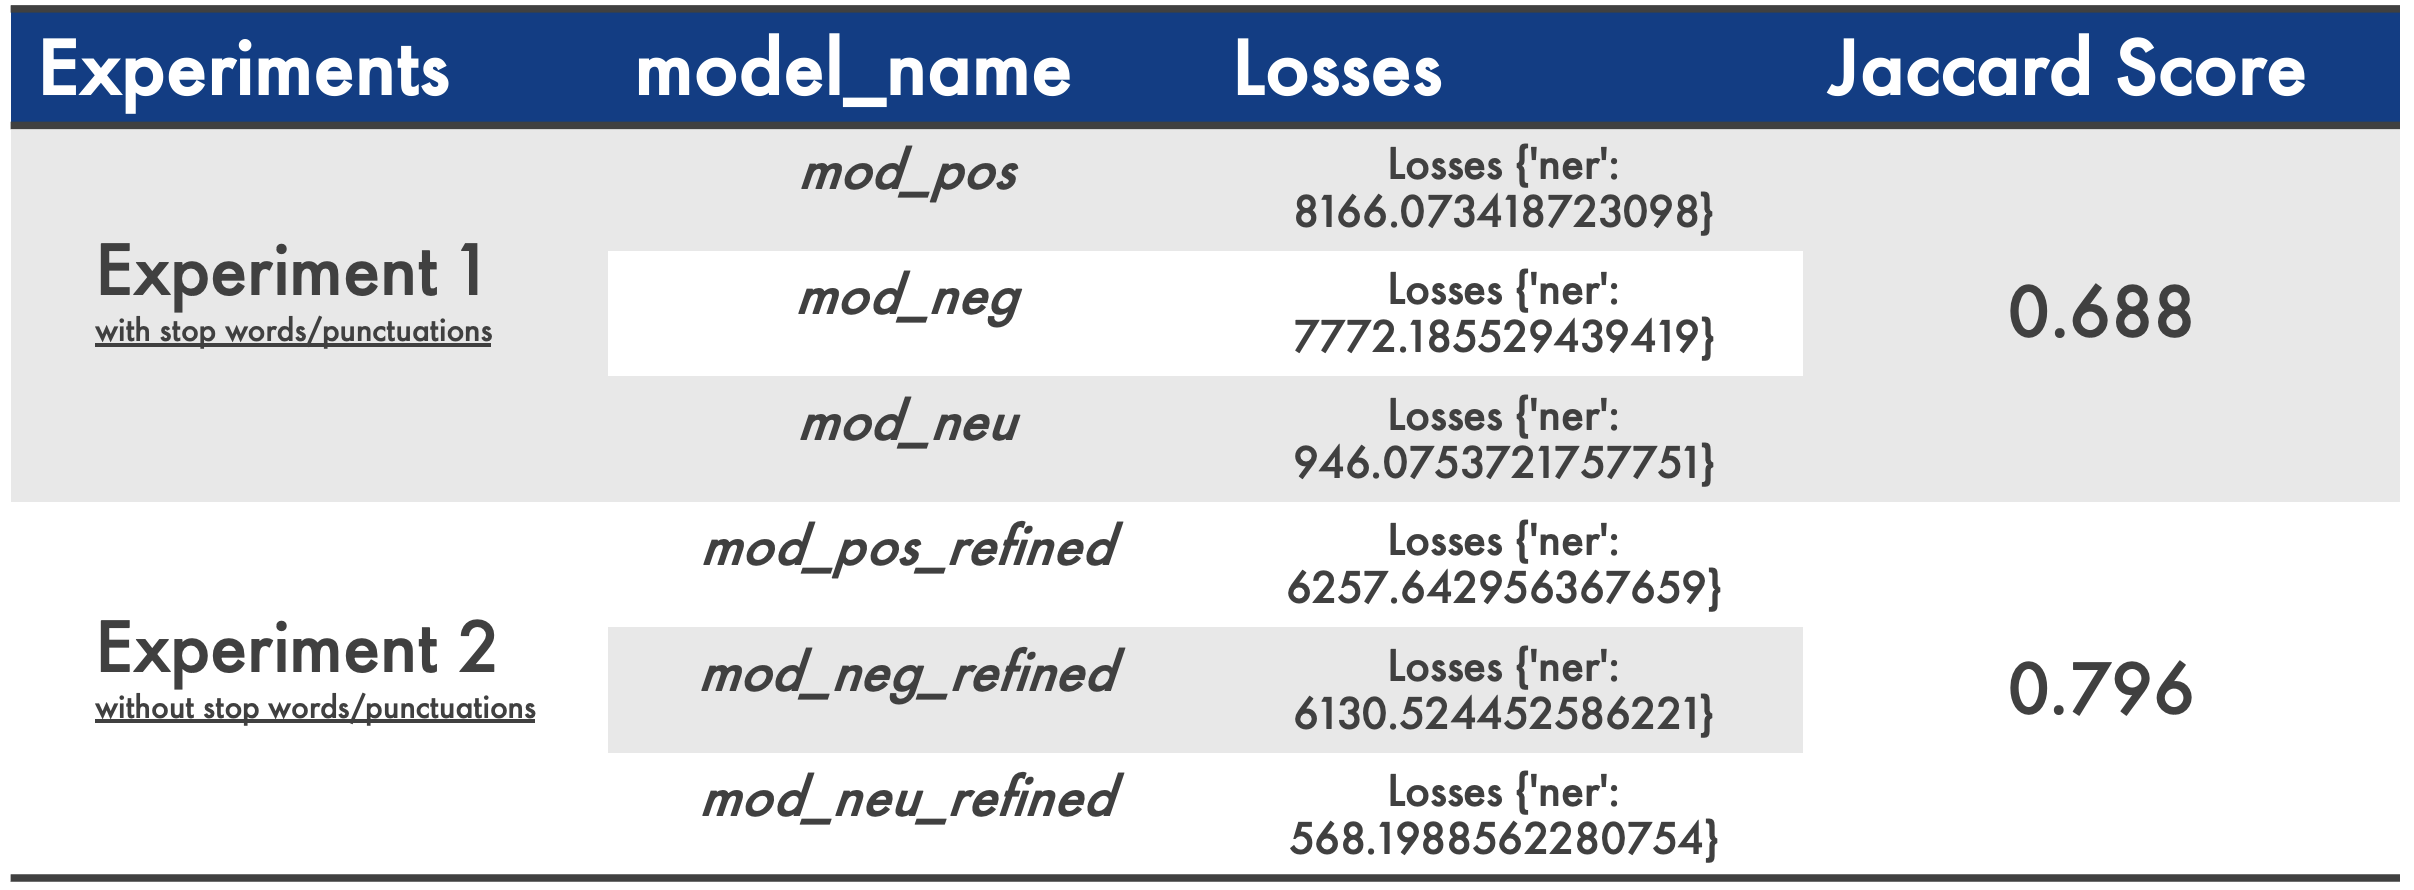

**So we can see how specific processing steps like removing stop-words and punctuations helped us improve accuracy**  
The above code is generic and can be used in the same format for different datasets/use-cases.

In [23]:
# Let's test our model on the test_data
test_data['selected_text'] = None
for index, row in tqdm(test_data.iterrows(), total=test_data.shape[0]):
    text = row.text
    try:
        if row.sentiment == 'neutral':
            selected_text = predict_entities(text, model_neu)
        elif row.sentiment == 'positive':
            selected_text = predict_entities(text, model_pos)
        else:
            selected_text = predict_entities(text, model_neg)
    except:
        continue
    row.selected_text = selected_text
    
test_data.head(10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3534/3534 [00:20<00:00, 174.87it/s]


,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,Recession
3,01082688c6,happy bday!,positive,happy
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,I like it
5,726e501993,that`s great!! weee!! visitors!,positive,that`s great
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,"soooooo wish i could, but"
8,e64208b4ef,and within a short time of the last clue all ...,neutral,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,What did you get? My day is alright.. haven`...


In [24]:
# Making Submission

sample_submission_data['selected_text'] = test_data['selected_text']
sample_submission_data.head(10)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,Recession
3,01082688c6,happy
4,33987a8ee5,I like it
5,726e501993,that`s great
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but"
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...


## Section 5:

### Reflection
Our findings:
1. People tend to explain their reasoning behind a `Neutral` review.  
2. Quite a few stopwords and punctuations removed. This resulted in increased `Jaccard Score`, measuring the capability of oure power of predicting correct texts.  
3. No major missings rows or data transformation required apart form extracting entities logically given that sentences are in sequence.  
4. Word2Vec provides great functionality to represent data in more high dimensional data which helped `stopwords and punctuation removal` in increased performance.  
5. Given there is no specific loss for our particular problem statement, so we opted for `Jaccard Index` as our evaluation metric. The greater the score, the more the trainel pipeline can identify correct texts.

### Improvement

1. There could be couple of more data-transformation techniques applied.  
2. Using other w2v libraries could help in project data much better.  
3. Using Lemmatizing/Stemming, could get rid of certain noisy words and help more towards JI score.
4. If required, we can even train our Custom NER model. Check the notebook `Custom NER - Spacy.ipynb`.


We talk more about **Spacy NER in `Spacy components working.ipynb`** attached to the repo and everything is articulated in the below Medium Post.
https://medium.com/p/3ddd323c6b2e/edit  

### Refrences:

1. https://github.com/mishra-atul5001/Data-Science-and-ML-insights-Projects/blob/master/Tweet%20Clustering.ipynb
2. https://www.kaggle.com/code/rohitsingh9990/ner-training-using-spacy-ensemble/notebook
3. https://www.youtube.com/watch?v=qROvu7kjF-U
4. **`ChatGPT`**

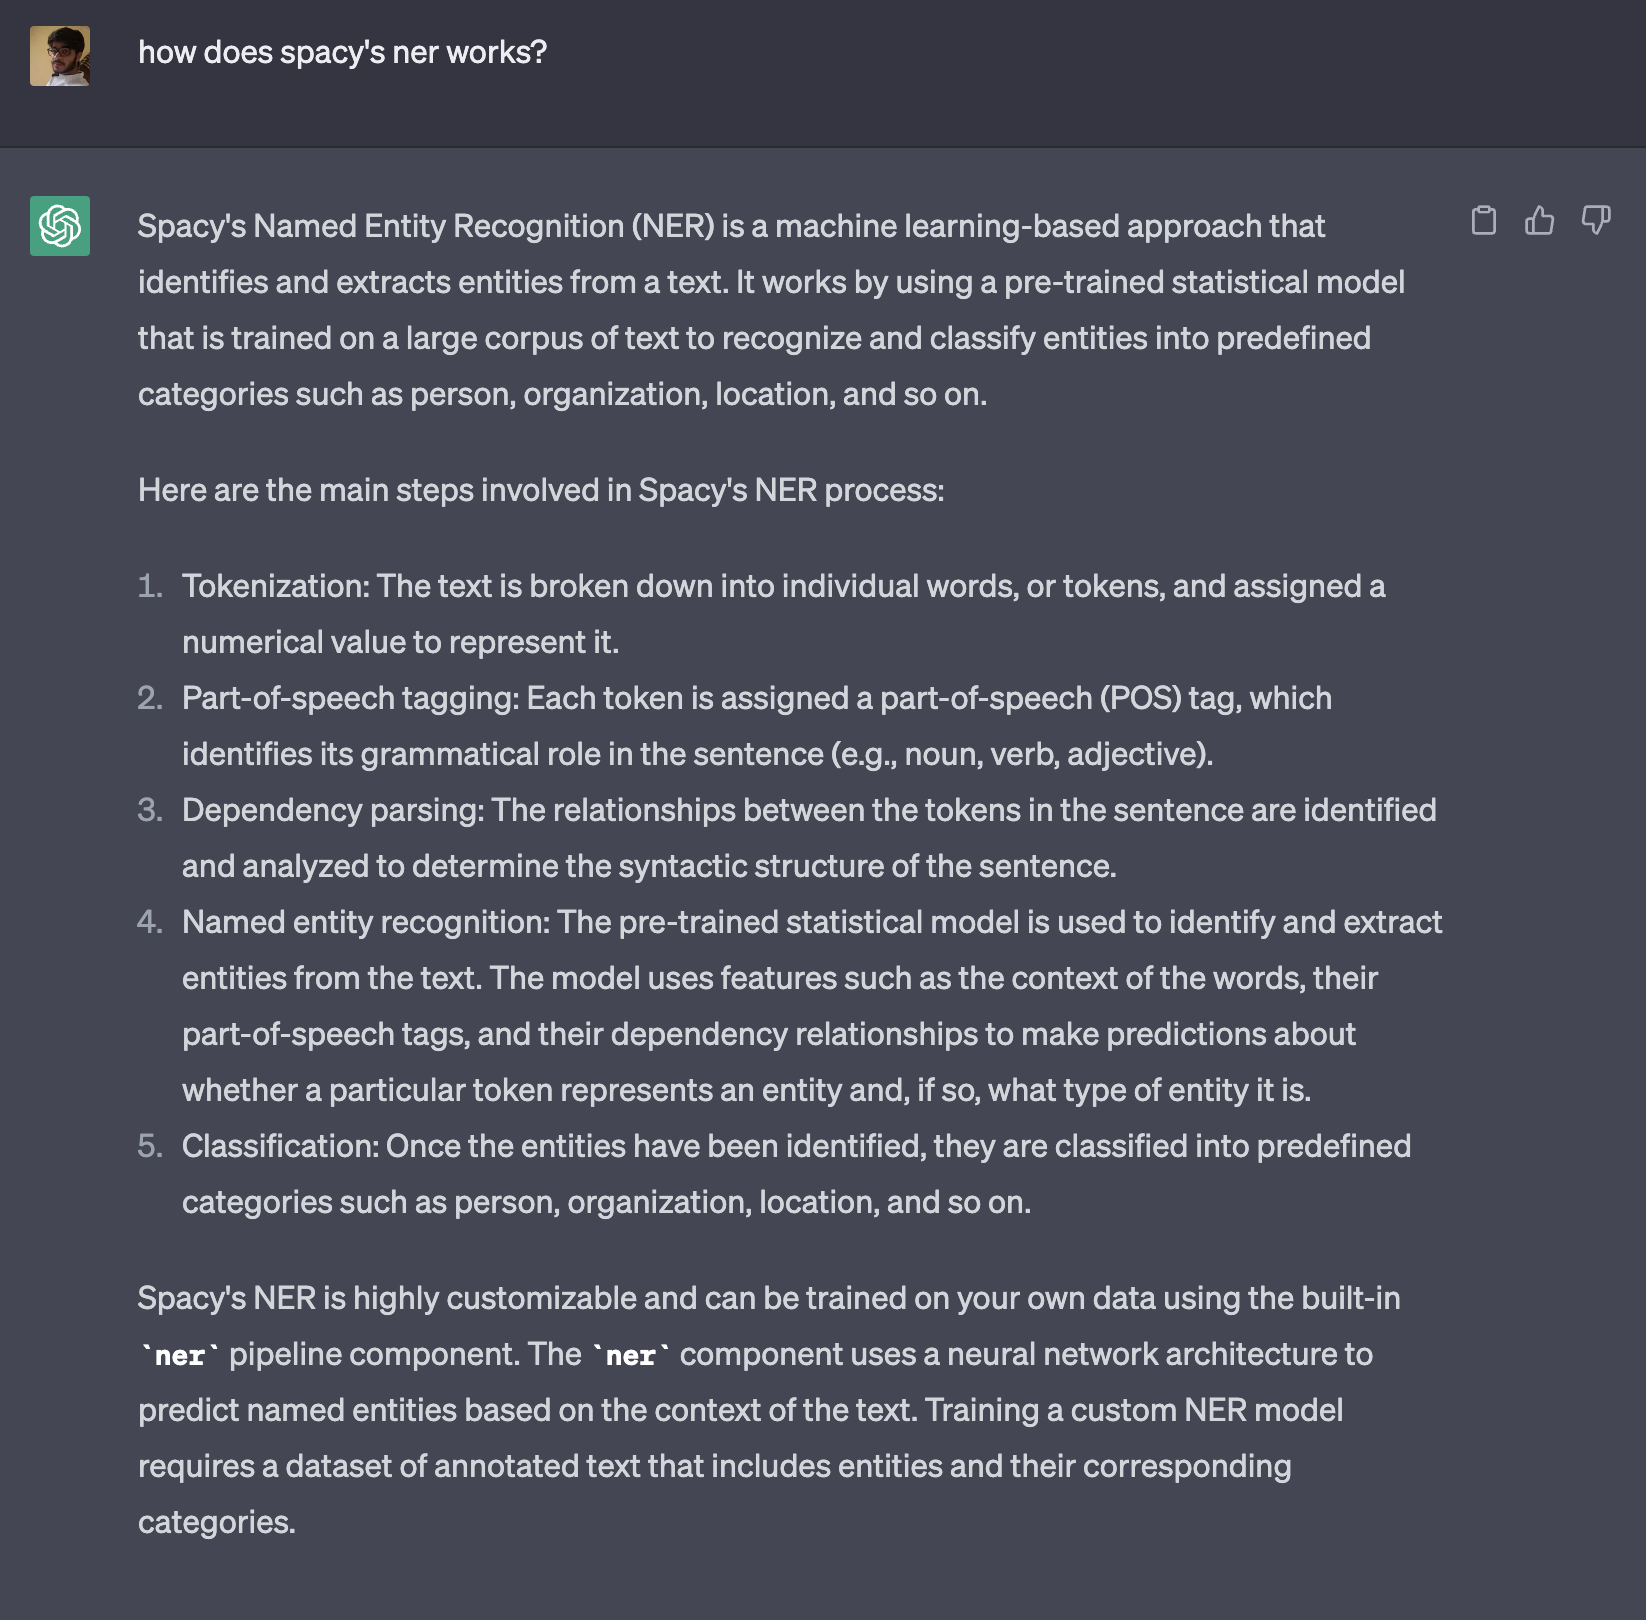